In [1]:
import anndata
import numpy as np
import gc
import scanpy as sc
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

In [2]:
expr_path = '/data/scRNA/ABCA/AIBS/AWS/expression_matrices/MERFISH-C57BL6J-638850-imputed/20240831/C57BL6J-638850-imputed-log2-wmeta.h5ad'
adata = sc.read_h5ad(expr_path)
adata

AnnData object with n_obs × n_vars = 3938808 × 8460
    obs: 'brain_section_label', 'cluster_alias', 'average_correlation_score', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color'
    var: 'gene_symbol'

**Load modules dataframe**

In [ ]:
modules_df = pd.read_csv(
    "/data/scRNA/ABCA/AIBS/AWS/expression_matrices/WMB-10Xv3/20230630/outputs/WMB-10Xv3-Isocortex-1-raw-sc-wgcna-modules.csv",
    index_col = "Unnamed: 0")
print("All module colors (names): ", modules_df["color"].unique())
modules_df.head()

All module colors (names):  ['green' 'brown' 'grey' 'blue' 'turquoise' 'yellow' 'red']


,gene_name,module,color,kME_green,kME_brown,kME_grey,kME_blue,kME_turquoise,kME_yellow,kME_red
ENSMUSG00000015090,ENSMUSG00000015090,green,green,0.653472,-0.032236,-0.115646,0.123502,0.069904,0.154395,-0.175664
ENSMUSG00000031425,ENSMUSG00000031425,green,green,0.921549,-0.047739,-0.106292,0.077948,0.088522,0.202247,-0.212231
ENSMUSG00000115529,ENSMUSG00000115529,green,green,0.283788,-0.010976,-0.029480,0.021220,0.017650,0.086082,-0.085927
ENSMUSG00000029819,ENSMUSG00000029819,brown,brown,-0.017231,0.547982,-0.066836,-0.008960,-0.004381,0.005224,-0.110663
ENSMUSG00000024610,ENSMUSG00000024610,grey,grey,0.007531,-0.025541,-0.034615,0.028825,0.155726,0.004847,-0.031323


Steps to get Module Eigengenes for MERFISH cells:
- Select genes for each module
- Select cells for the brain region
- Process the gene expression data
- Compute PC1
- Visualize

In [4]:
select_module = "green"
select_genes = modules_df[modules_df["module"] == select_module].index
print("Number of genes in the module: ", select_genes.shape[0])
common_genes = adata.var_names.intersection(select_genes)
adata_subset = adata[:,common_genes].copy()
adata_subset

Number of genes in the module:  119


AnnData object with n_obs × n_vars = 3938808 × 113
    obs: 'brain_section_label', 'cluster_alias', 'average_correlation_score', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color'
    var: 'gene_symbol'

In [5]:
# sc.pp.filter_cells(adata_subset, min_genes=5)
# sc.pp.normalize_total(adata_subset, target_sum=1e4)
# sc.pp.log1p(adata_subset)
adata_subset.X = adata_subset.X.astype("float32")
sc.pp.scale(adata_subset, max_value=10)
sc.tl.pca(adata_subset, n_comps=2, svd_solver="arpack")
adata_subset

AnnData object with n_obs × n_vars = 3938808 × 113
    obs: 'brain_section_label', 'cluster_alias', 'average_correlation_score', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color'
    var: 'gene_symbol', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [6]:
def plot_pca(xx, yy, cc=None, val=None, adata=None, pc_component=None, 
                 fig_width=8, fig_height=8, cmap=None, cbar_label=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    scatter_plot = None  # To hold the scatter plot object
    
    # PCA component coloring
    if pc_component is not None:
        if adata is None:
            raise ValueError("adata must be provided when using pc_component.")
        val = adata.obsm['X_pca'][:, pc_component]
        cmap = cmap or 'viridis'
        scatter_plot = ax.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
        cbar_label = cbar_label or f'PC{pc_component + 1}'  # Auto-label for PCA
        
    # Regular colormap coloring
    elif cmap is not None:
        scatter_plot = ax.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
        cbar_label = cbar_label or 'Value'  # Default label
        
    # Categorical color list
    elif cc is not None:
        ax.scatter(xx, yy, s=0.5, color=cc, marker='.')
        
    # Default to black
    else:
        ax.scatter(xx, yy, s=0.5, color='k', marker='.')
    
    # Add color bar if needed
    if scatter_plot is not None:
        cbar = fig.colorbar(scatter_plot, ax=ax, shrink=0.6, aspect=10)
        if cbar_label:
            cbar.set_label(cbar_label, rotation=270, labelpad=15)
    
    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return fig, ax

In [7]:
adata_section = adata_subset[adata_subset.obs['brain_section_label'] == 'C57BL6J-638850.38']
adata_section

View of AnnData object with n_obs × n_vars = 120186 × 113
    obs: 'brain_section_label', 'cluster_alias', 'average_correlation_score', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color'
    var: 'gene_symbol', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

(<Figure size 800x800 with 2 Axes>, <Axes: >)

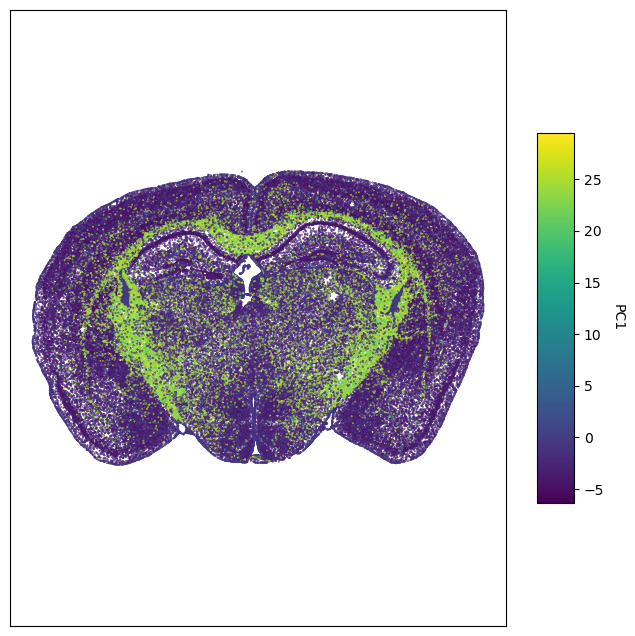

In [8]:
plot_pca(adata_section.obs['x'], adata_section.obs['y'], adata=adata_section, pc_component=0, cmap='viridis')

In [79]:
del adata_subset, adata_section